In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

import random

df = pd.read_csv('merged.csv').fillna(0)


Split the data into train and validation sets using two strategies - based on regions and based on time.

In [205]:
# in total 16  states, leave 1 state for test, other 12 states as train, 3 as val
# allRegionsBased = df.set_index('open_covid_region_code')
# allRegionsBased= allRegionsBased.groupby(df.index).filter(lambda x: True)

regions = list(dict.fromkeys(list(df['open_covid_region_code'])))

random.shuffle(regions)

regions
#print(len(regions))

['US-AK',
 'US-MT',
 'US-WY',
 'US-NM',
 'US-ND',
 'US-SD',
 'US-DC',
 'US-WV',
 'US-ID',
 'US-NH',
 'US-HI',
 'US-ME',
 'US-DE',
 'US-VT',
 'US-NE',
 'US-RI']

In [206]:
print(regions[len(regions)-1])

US-RI


In [207]:
#define a function for the MSE loss
loss = lambda y, yh: np.mean((y-yh)**2)


In [208]:
kf = KFold(n_splits=5)
K_list = range(1,100)
err_validKNN=np.zeros((len(K_list), 5))
err_testKNN=np.zeros(len(K_list))

err_validDT=np.zeros((len(K_list), 5))
err_testDT=np.zeros(len(K_list))

#test set
test_region = np.array(regions)[len(regions)-1]
dat_test_region = df.loc[df['open_covid_region_code'].isin([test_region])]
x_test_region = dat_test_region.iloc[:, 7:-1].to_numpy()
y_test_region = dat_test_region.iloc[:, -1].to_numpy()

#rest set
rest_region = np.array(regions)[:len(regions)-1]
dat_rest_region = df.loc[df['open_covid_region_code'].isin(list(rest_region))]
x_rest_region = dat_rest_region.iloc[:, 7:-1].to_numpy()
y_rest_region = dat_rest_region.iloc[:, -1].to_numpy()


BEST TEST K for KNN REGION split: 6
Best TEST MSE for KNN REGION split: 14235.967741935483
BEST K for KNN REGION split: 60
Best MSE for KNN REGION split: 3718.6032030864203


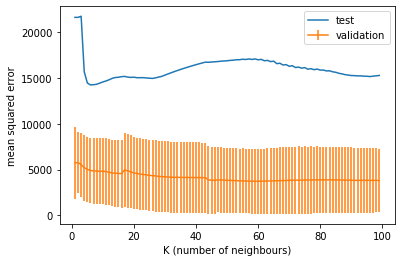

BEST TEST K for DT REGION split: 82
Best TEST MSE for DT REGION split: 21091.244955617694
BEST K for DecisionTree REGION split: 79
Best MSE for DecisionTree REGION split: 3251.1060892191795


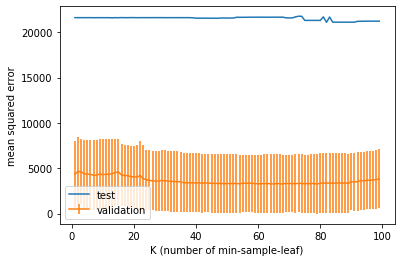

In [209]:
#keep using dataset while spliting          REGION!!!!! KNN

for i, K in enumerate(K_list):
  ##Find the validation errors for num_folds splits for a given K
  for f, (train_ind,val_ind) in enumerate(kf.split(regions[:len(regions)-1])):  #leave out the last region  
      train_region = np.array(regions)[train_ind]
      val_region = np.array(regions)[val_ind]
      
      dat_train_region = df.loc[df['open_covid_region_code'].isin(train_region)]
      dat_val_region = df.loc[df['open_covid_region_code'].isin(val_region)]
      x_train_region = dat_train_region.iloc[:, 7:-1].to_numpy()
      y_train_region = dat_train_region.iloc[:, -1].to_numpy()
      x_val_region = dat_val_region.iloc[:, 7:-1].to_numpy()
      y_val_region = dat_val_region.iloc[:, -1].to_numpy()
      
      modelKNN = KNeighborsRegressor(n_neighbors=K)
      modelKNN = modelKNN.fit(x_train_region, y_train_region)
      err_validKNN[i,f] = loss(y_val_region, modelKNN.predict(x_val_region))

      modelDT = DecisionTreeRegressor(min_samples_leaf=K)
      modelDT = modelDT.fit(x_train_region, y_train_region)
      err_validDT[i,f] = loss(y_val_region, modelDT.predict(x_val_region))
  
  modelKNN = KNeighborsRegressor(n_neighbors=K)
  modelKNN = modelKNN.fit(x_rest_region, y_rest_region)
  err_testKNN[i]= loss(y_test_region, modelKNN.predict(x_test_region))
      
  modelDT = DecisionTreeRegressor(min_samples_leaf=K,random_state=0)
  modelDT = modelDT.fit(x_rest_region, y_rest_region)
  err_testDT[i]= loss(y_test_region, modelDT.predict(x_test_region))

bestKNN= np.argmin(np.mean(err_validKNN, axis=1)) + 1
bestKNNTestInd = np.argmin(err_testKNN) + 1
bestKNNTestMSE = err_testKNN[bestKNNTestInd - 1]
print("BEST TEST K for KNN REGION split:",bestKNNTestInd)
print("Best TEST MSE for KNN REGION split:",bestKNNTestMSE)
print("BEST K for KNN REGION split:",bestKNN)
print("Best MSE for KNN REGION split:",np.mean(err_validKNN, axis=1)[bestKNN - 1])
plt.plot(K_list, err_testKNN,  label='test')
plt.errorbar(K_list, np.mean(err_validKNN, axis=1), np.std(err_validKNN, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

bestDT= np.argmin(np.mean(err_validDT, axis=1)) + 1
bestDTTestInd = np.argmin(err_testDT) + 1
bestDTTestMSE = err_testDT[bestDTTestInd - 1]
print("BEST TEST K for DT REGION split:",bestDTTestInd)
print("Best TEST MSE for DT REGION split:",bestDTTestMSE)
print("BEST K for DecisionTree REGION split:",bestDT)
print("Best MSE for DecisionTree REGION split:",np.mean(err_validDT, axis=1)[bestDT - 1])
plt.plot(K_list, err_testDT,  label='test')
plt.errorbar(K_list, np.mean(err_validDT, axis=1), np.std(err_validDT, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of min-sample-leaf)')
plt.ylabel('mean squared error')
plt.show()

In [210]:
#keep using dataset while spliting          DATE!!!!!
df['date'] = pd.to_datetime(df['date'])
dat_train_date = df.loc[df['date'] <= pd.to_datetime('2020-08-10')]
dat_val_date = df.loc[df['date'] > pd.to_datetime('2020-08-10')]
x_train_date = dat_train_date.iloc[:, 7:-1].to_numpy()
y_train_date = dat_train_date.iloc[:, -1].to_numpy()
x_val_date = dat_val_date.iloc[:, 7:-1].to_numpy()
y_val_date = dat_val_date.iloc[:, -1].to_numpy()
#print(x_train_date[:2])
#print(x_val_date[:2])
#yield x_train, y_train, x_val, y_val

BEST K for KNN DATE split: 3
Best MSE for KNN DATE split: 1071.5046296296296


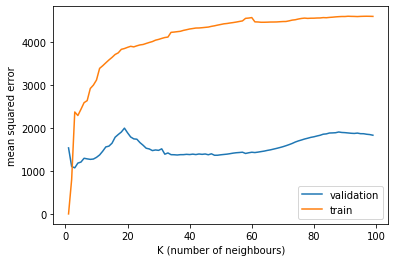

In [211]:
#KNN DATE PART

#Plot the mean square error for different K values stored in K_list
K_list = range(1,100)
err_train, err_val= [], []

for i, K in enumerate(K_list):
    model = KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train_date, y_train_date)
    prediction_train_date = model.predict(x_train_date)
    err_val.append(loss(model.predict(x_val_date), y_val_date))
    err_train.append(loss(prediction_train_date, y_train_date))
    
best= np.argmin(err_val) + 1
print("BEST K for KNN DATE split:",best)
print("Best MSE for KNN DATE split:",err_val[best - 1])
plt.plot(K_list, err_val, '-', label='validation')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

# plt.plot(K_list, accuracy_train, '-', label='accuracy_train')
# plt.plot(K_list, accuracy_val, '-', label='accuracy_val')
# plt.legend()
# plt.xlabel('K (number of neighbours)')
# plt.ylabel('accuracy')
# plt.show()

BEST K for DecisionTree DATE split: 7
Best MSE for DecisionTree DATE split: 1261.2578812814268


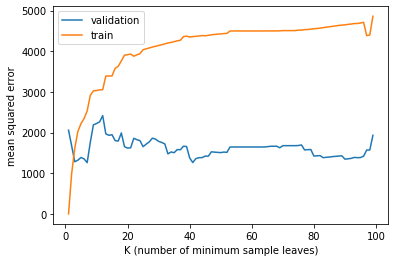

In [212]:
#Decision Tree DATE part
#Plot the mean square error for different K values stored in K_list

err_train_date, err_val_date= [], []
# accuracy_train,accuracy_val = [], []
for i, K in enumerate(K_list):
    model = DecisionTreeRegressor(min_samples_leaf=K,random_state=0)
    model = model.fit(x_train_date, y_train_date)
    prediction_train_date = model.predict(x_train_date)
    err_val_date.append(loss(model.predict(x_val_date), y_val_date))
    err_train_date.append(loss(prediction_train_date, y_train_date))
    # accuracy_train.append(model.score(x_train_date,y_train_date))
    # accuracy_val.append(model.score(x_val_date,y_val_date))

best= np.argmin(err_val_date) + 1
print("BEST K for DecisionTree DATE split:",best)
print("Best MSE for DecisionTree DATE split:",err_val_date[best - 1])
plt.plot(K_list, err_val_date, '-', label='validation')
plt.plot(K_list, err_train_date, '-', label='train')
plt.legend()
plt.xlabel('K (number of minimum sample leaves)')
plt.ylabel('mean squared error')
plt.show()


In [213]:
#Based on the visualization of task 2, we found rhode Island，Delaware，Columbia，West Virginia has the most complete covergae of the 20 most popular symptoms,
#therefore we decided to model these regions hospitalization with the 20 most popular symptoms using cross validation.

popularData = df.loc[:,"symptom:Adrenal crisis":"symptom:Yawn"].count().sort_values(ascending=False).head(20)
symptomList = popularData.index.tolist()

regions=list([
 'US-DC',
 'US-DE',
 'US-RI',
 'US-WV'])

kf = KFold(n_splits=4)
K_list = range(1,90)
err_validKNN=np.zeros((len(K_list), 4))
err_validDT=np.zeros((len(K_list), 4))

for i, K in enumerate(K_list):
  ##Find the validation errors for num_folds splits for a given K
  for f, (train_ind,val_ind) in enumerate(kf.split(regions)):  
      train_region = np.array(regions)[train_ind]
      val_region = np.array(regions)[val_ind]
      
      dat_train_region = df.loc[df['open_covid_region_code'].isin(train_region)]
      dat_val_region = df.loc[df['open_covid_region_code'].isin(val_region)]
      x_train_region = dat_train_region.loc[:,symptomList].to_numpy()
      y_train_region = dat_train_region.iloc[:, -1].to_numpy()
      x_val_region = dat_val_region.loc[:,symptomList].to_numpy()
      y_val_region = dat_val_region.iloc[:, -1].to_numpy()
      
      modelKNN = KNeighborsRegressor(n_neighbors=K)
      modelKNN = modelKNN.fit(x_train_region, y_train_region)
      err_validKNN[i,f] = loss(y_val_region, modelKNN.predict(x_val_region))

      modelDT = DecisionTreeRegressor(min_samples_leaf=K)
      modelDT = modelDT.fit(x_train_region, y_train_region)
      err_validDT[i,f] = loss(y_val_region, modelDT.predict(x_val_region))


BEST K for KNN REGION split: 88
Best MSE for KNN REGION split: 6044.563990921865


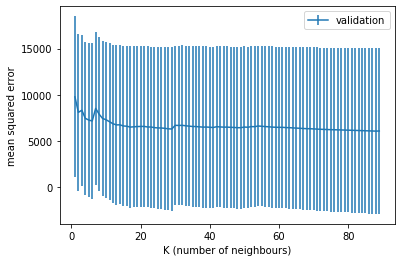

BEST K for DecisionTree REGION split: 46
Best MSE for DecisionTree REGION split: 6074.441564703759


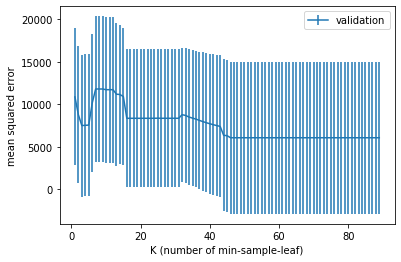

In [214]:
bestKNN= np.argmin(np.mean(err_validKNN, axis=1)) + 1
print("BEST K for KNN REGION split:",bestKNN)
print("Best MSE for KNN REGION split:",np.mean(err_validKNN, axis=1)[bestKNN - 1])
#plt.plot(K_list, err_testKNN,  label='test')
plt.errorbar(K_list, np.mean(err_validKNN, axis=1), np.std(err_validKNN, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

bestDT= np.argmin(np.mean(err_validDT, axis=1)) + 1
print("BEST K for DecisionTree REGION split:",bestDT)
print("Best MSE for DecisionTree REGION split:",np.mean(err_validDT, axis=1)[bestDT - 1])
#plt.plot(K_list, err_testDT,  label='test')
plt.errorbar(K_list, np.mean(err_validDT, axis=1), np.std(err_validDT, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of min-sample-leaf)')
plt.ylabel('mean squared error')
plt.show()

BEST K for KNN DATE split: 1 in region: US-AK
Best MSE for KNN DATE split: 0.0


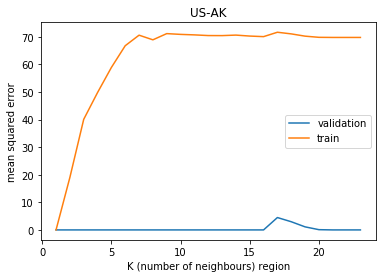

BEST K for KNN DATE split: 1 in region: US-DC
Best MSE for KNN DATE split: 0.0


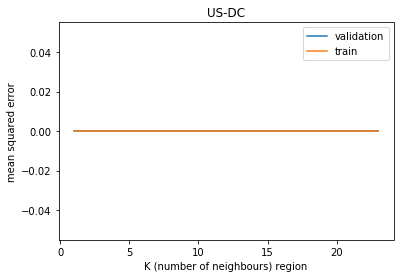

BEST K for KNN DATE split: 1 in region: US-DE
Best MSE for KNN DATE split: 0.0


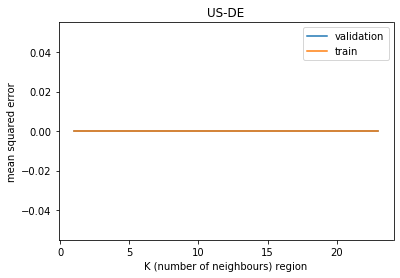

BEST K for KNN DATE split: 2 in region: US-HI
Best MSE for KNN DATE split: 2552.9166666666665


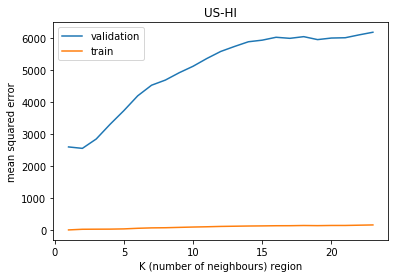

BEST K for KNN DATE split: 1 in region: US-ID
Best MSE for KNN DATE split: 241.0


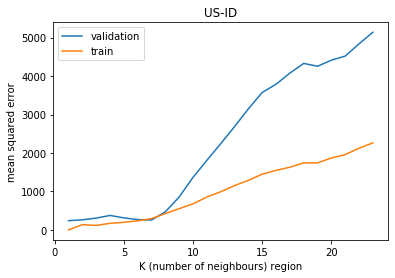

BEST K for KNN DATE split: 7 in region: US-ME
Best MSE for KNN DATE split: 5.962585034013606


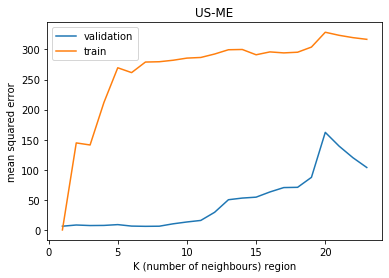

BEST K for KNN DATE split: 1 in region: US-MT
Best MSE for KNN DATE split: 712.8333333333334


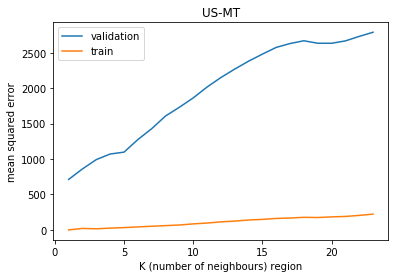

BEST K for KNN DATE split: 1 in region: US-ND
Best MSE for KNN DATE split: 614.3333333333334


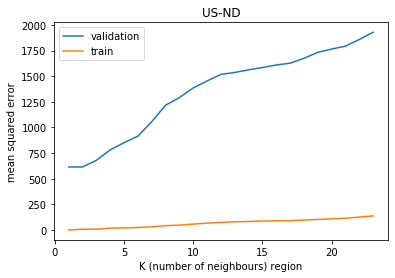

BEST K for KNN DATE split: 7 in region: US-NE
Best MSE for KNN DATE split: 671.3061224489795


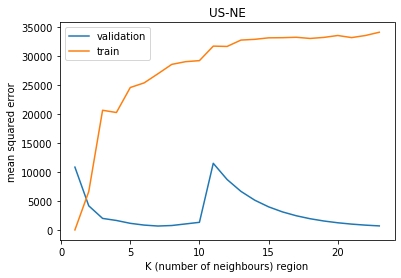

BEST K for KNN DATE split: 2 in region: US-NH
Best MSE for KNN DATE split: 11.583333333333334


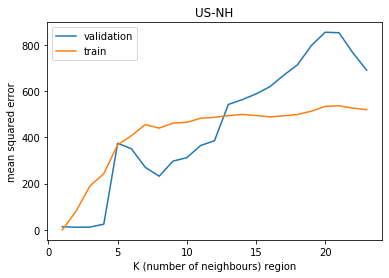

BEST K for KNN DATE split: 1 in region: US-NM
Best MSE for KNN DATE split: 1766.6666666666667


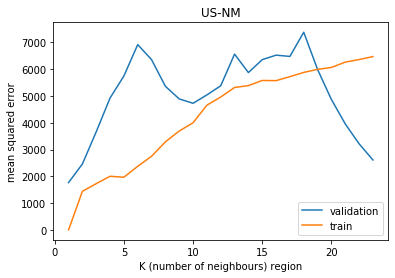

BEST K for KNN DATE split: 8 in region: US-RI
Best MSE for KNN DATE split: 223.64583333333334


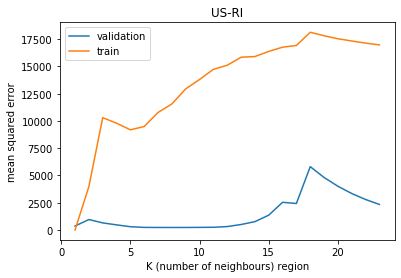

BEST K for KNN DATE split: 17 in region: US-SD
Best MSE for KNN DATE split: 4225.035178777393


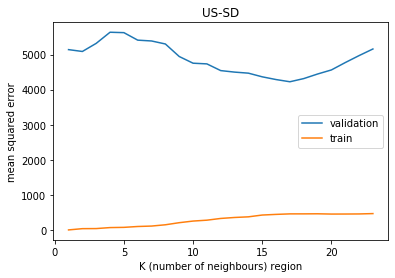

BEST K for KNN DATE split: 1 in region: US-VT
Best MSE for KNN DATE split: 0.0


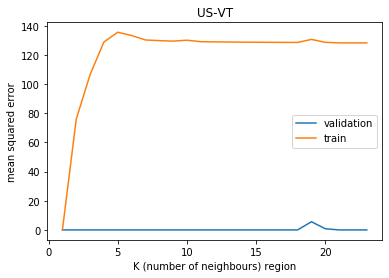

BEST K for KNN DATE split: 1 in region: US-WV
Best MSE for KNN DATE split: 0.0


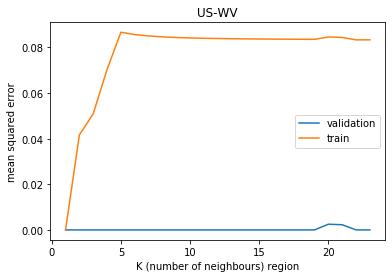

BEST K for KNN DATE split: 2 in region: US-WY
Best MSE for KNN DATE split: 27.166666666666668


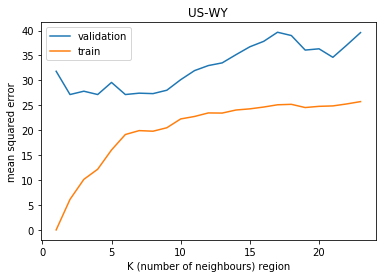

In [215]:
#try predicting each region
df['date'] = pd.to_datetime(df['date'])
dat_train_date = df.loc[df['date'] <= pd.to_datetime('2020-08-10')]
dat_val_date = df.loc[df['date'] > pd.to_datetime('2020-08-10')]


regions = list(dict.fromkeys(list(df['open_covid_region_code'])))

K_list=range(1,24)

for region in regions:
    
    train_date_region = dat_train_date.loc[df['open_covid_region_code'].isin([region])]
    val_date_region = dat_val_date.loc[df['open_covid_region_code'].isin([region])]
    
    x_train_date = train_date_region.iloc[:, 7:-1].to_numpy()
    y_train_date = train_date_region.iloc[:, -1].to_numpy()
    
    x_val_date = val_date_region.iloc[:, 7:-1].to_numpy()
    y_val_date = val_date_region.iloc[:, -1].to_numpy()
    
    err_train, err_val= [], []

    for i, K in enumerate(K_list):
        model = KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_train_date, y_train_date)
        prediction_train_date = model.predict(x_train_date)
        err_val.append(loss(model.predict(x_val_date), y_val_date))
        err_train.append(loss(prediction_train_date, y_train_date))

    best= np.argmin(err_val) + 1
    print("BEST K for KNN DATE split:",best, "in region:", region)
    print("Best MSE for KNN DATE split:",err_val[best - 1])
    plt.plot(K_list, err_val, '-', label='validation')
    plt.plot(K_list, err_train, '-', label='train')
    plt.legend()
    plt.title(region)
    plt.xlabel('K (number of neighbours) region')
    plt.ylabel('mean squared error')
    plt.show()
    

BEST K for DecisionTree DATE split: 2 in region: US-AK
Best MSE for DecisionTree DATE split: 0.0


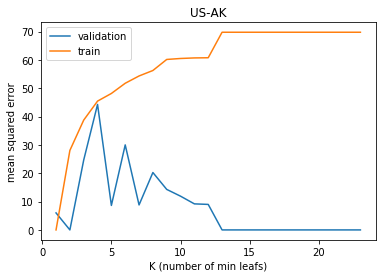

BEST K for DecisionTree DATE split: 1 in region: US-DC
Best MSE for DecisionTree DATE split: 0.0


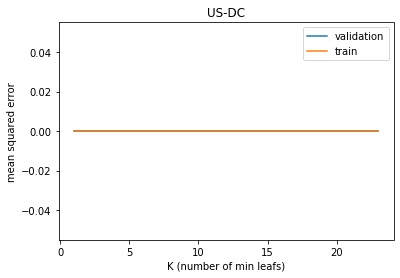

BEST K for DecisionTree DATE split: 1 in region: US-DE
Best MSE for DecisionTree DATE split: 0.0


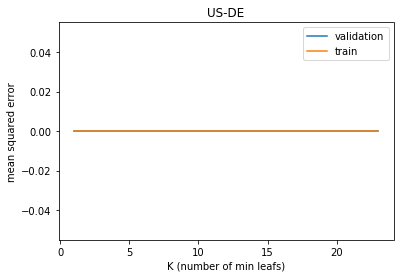

BEST K for DecisionTree DATE split: 1 in region: US-HI
Best MSE for DecisionTree DATE split: 2534.5


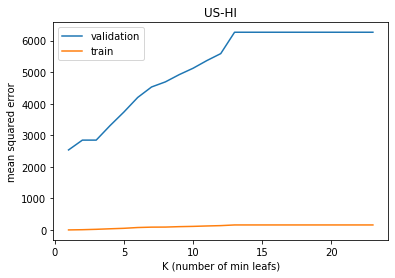

BEST K for DecisionTree DATE split: 7 in region: US-ID
Best MSE for DecisionTree DATE split: 257.0


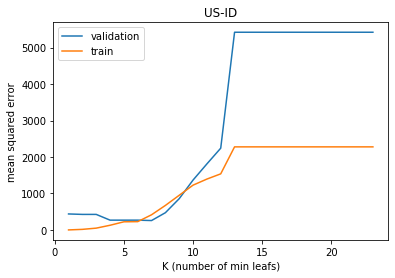

BEST K for DecisionTree DATE split: 1 in region: US-ME
Best MSE for DecisionTree DATE split: 26.166666666666668


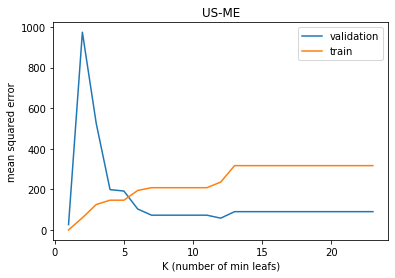

BEST K for DecisionTree DATE split: 3 in region: US-MT
Best MSE for DecisionTree DATE split: 1097.7933333333335


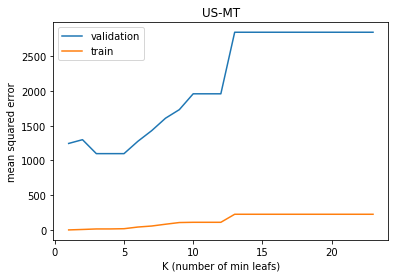

BEST K for DecisionTree DATE split: 4 in region: US-ND
Best MSE for DecisionTree DATE split: 915.9166666666666


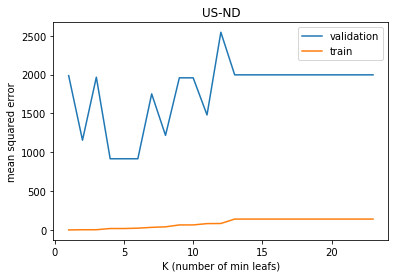

BEST K for DecisionTree DATE split: 13 in region: US-NE
Best MSE for DecisionTree DATE split: 597.2100694444443


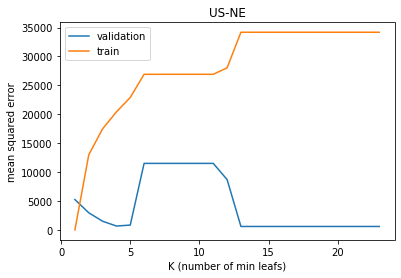

BEST K for DecisionTree DATE split: 4 in region: US-NH
Best MSE for DecisionTree DATE split: 18.401360544217685


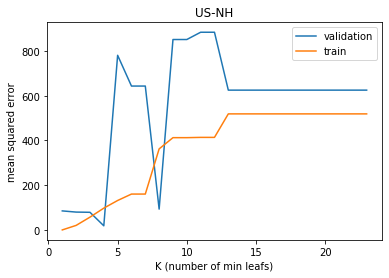

BEST K for DecisionTree DATE split: 13 in region: US-NM
Best MSE for DecisionTree DATE split: 2115.432291666666


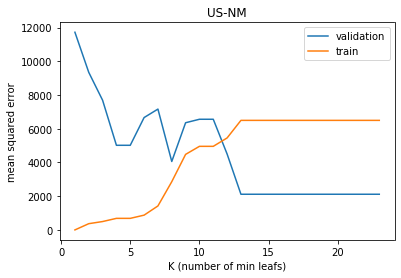

BEST K for DecisionTree DATE split: 3 in region: US-RI
Best MSE for DecisionTree DATE split: 342.01407407407413


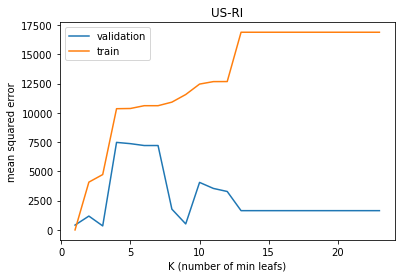

BEST K for DecisionTree DATE split: 4 in region: US-SD
Best MSE for DecisionTree DATE split: 4879.765306122449


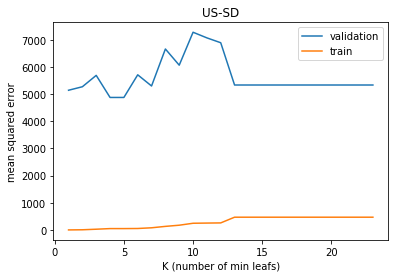

BEST K for DecisionTree DATE split: 1 in region: US-VT
Best MSE for DecisionTree DATE split: 0.0


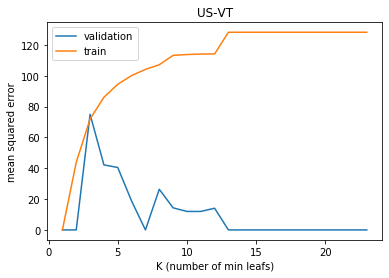

BEST K for DecisionTree DATE split: 1 in region: US-WV
Best MSE for DecisionTree DATE split: 0.0


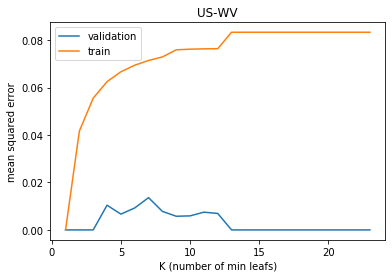

BEST K for DecisionTree DATE split: 10 in region: US-WY
Best MSE for DecisionTree DATE split: 29.137822550409965


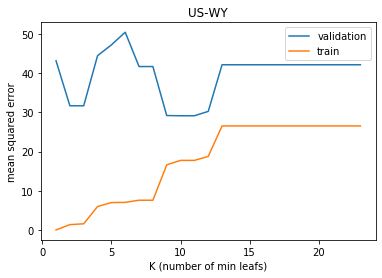

In [216]:
for region in regions:
    
    train_date_region = dat_train_date.loc[df['open_covid_region_code'].isin([region])]
    val_date_region = dat_val_date.loc[df['open_covid_region_code'].isin([region])]
    
    x_train_date = train_date_region.iloc[:, 7:-1].to_numpy()
    y_train_date = train_date_region.iloc[:, -1].to_numpy()
    
    x_val_date = val_date_region.iloc[:, 7:-1].to_numpy()
    y_val_date = val_date_region.iloc[:, -1].to_numpy()
    
    err_train, err_val= [], []

    for i, K in enumerate(K_list):
        model = DecisionTreeRegressor(min_samples_leaf=K)
        model = model.fit(x_train_date, y_train_date)
        prediction_train_date = model.predict(x_train_date)
        err_val.append(loss(model.predict(x_val_date), y_val_date))
        err_train.append(loss(prediction_train_date, y_train_date))

    best= np.argmin(err_val) + 1
    print("BEST K for DecisionTree DATE split:",best, "in region:", region)
    print("Best MSE for DecisionTree DATE split:",err_val[best - 1])
    plt.plot(K_list, err_val, '-', label='validation')
    plt.plot(K_list, err_train, '-', label='train')
    plt.legend()
    plt.title(region)
    plt.xlabel('K (number of min leafs)')
    plt.ylabel('mean squared error')
    plt.show()